In [ ]:
from milvus_chatbot_with_rag import retrieve_similiar_contexts

from datasets import Dataset
from ragas import evaluate
from ragas.metrics import context_precision, context_recall

from dotenv import load_dotenv
from openai import OpenAI
import os

# --- Load API Key ---
load_dotenv(override=True, dotenv_path="../.env")
my_api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=my_api_key)

# Example reference data
reference_data = [
    {
        "question": "What is the company's policy on remote work?",
        "ground_truth": "Remote work is allowed up to 3 days per week. Employees must coordinate with their managers and ensure they have a suitable home office setup.",
        "context": "Remote work is allowed up to 3 days per week."
    },
    {
        "question": "How and when employees are paid?",
        "ground_truth": "Employees are paid bi-weekly via direct deposit.",
        "context": "Employees are paid bi-weekly via direct deposit."
    },
    {
        "question": "When Vacation accrual starts from?",
        "ground_truth": "Vacation accrual starts after 90 days of employment.",
        "context": "Vacation accrual starts after 90 days of employment."
    },
    {
        "question": "When Performance reviews are conducted?",
        "ground_truth": "Performance reviews are conducted annually in December.",
        "context": "Performance reviews are conducted annually in December."
    }
]

results_list = []
# Example retrieval function
def perform_retrieval(question):
    # Replace this with your actual retrieval function
    retrieved_context = retrieve_similiar_contexts(question, "employee_policies", 1)[0]['content']
    return retrieved_context

# Step 1: Add retrieved context to reference data
for item in reference_data:
    item["retrieved_context"] = perform_retrieval(item["question"])

# Step 2: Build lists for ragas dataset
for item in reference_data:
    question = item["question"]
    reference_context = item["context"]
    retrieved_context = [perform_retrieval(question)]

    # Step 3: Build dataset dictionary
    dataset_dict = {
    "question": [question],
    "contexts": [retrieved_context],
    "ground_truth": [reference_context],
    "answer": [""]
}

    print(f"dataset_dict: {dataset_dict}")

    ragas_dataset = Dataset.from_dict(dataset_dict)

    # Step 5: Evaluate retrieval metrics
    metrics_result = evaluate(
        dataset=ragas_dataset,
        metrics=[context_precision, context_recall]
    )

    # Ensure scalar values
    precision_value = metrics_result["context_precision"]
    recall_value = metrics_result["context_recall"]

    # If lists, take average
    if isinstance(precision_value, list):
        precision_value = sum(precision_value)/len(precision_value)
    if isinstance(recall_value, list):
        recall_value = sum(recall_value)/len(recall_value)

    results_list.append({
        "question": question,
        "precision": precision_value,
        "recall": recall_value
    })


    print(metrics_result)

/Users/chandurajana/Documents/Chandu_Training/2025_09_GenAI_chandu/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dataset_dict: {'question': ["What is the company's policy on remote work?"], 'contexts': [['Remote work is allowed up to 3 days per week.']], 'ground_truth': ['Remote work is allowed up to 3 days per week.'], 'answer': ['']}


Evaluating: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


{'context_precision': 1.0000, 'context_recall': 1.0000}
dataset_dict: {'question': ['How and when employees are paid?'], 'contexts': [['Employees are paid bi-weekly via direct deposit.']], 'ground_truth': ['Employees are paid bi-weekly via direct deposit.'], 'answer': ['']}


Evaluating: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


{'context_precision': 1.0000, 'context_recall': 1.0000}
dataset_dict: {'question': ['When Vacation accrual starts from?'], 'contexts': [['Vacation accrual starts after 90 days of employment.']], 'ground_truth': ['Vacation accrual starts after 90 days of employment.'], 'answer': ['']}


Evaluating: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


{'context_precision': 1.0000, 'context_recall': 1.0000}
dataset_dict: {'question': ['When Performance reviews are conducted?'], 'contexts': [['Performance reviews are conducted annually in December.']], 'ground_truth': ['Performance reviews are conducted annually in December.'], 'answer': ['']}


Evaluating: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


{'context_precision': 1.0000, 'context_recall': 1.0000}


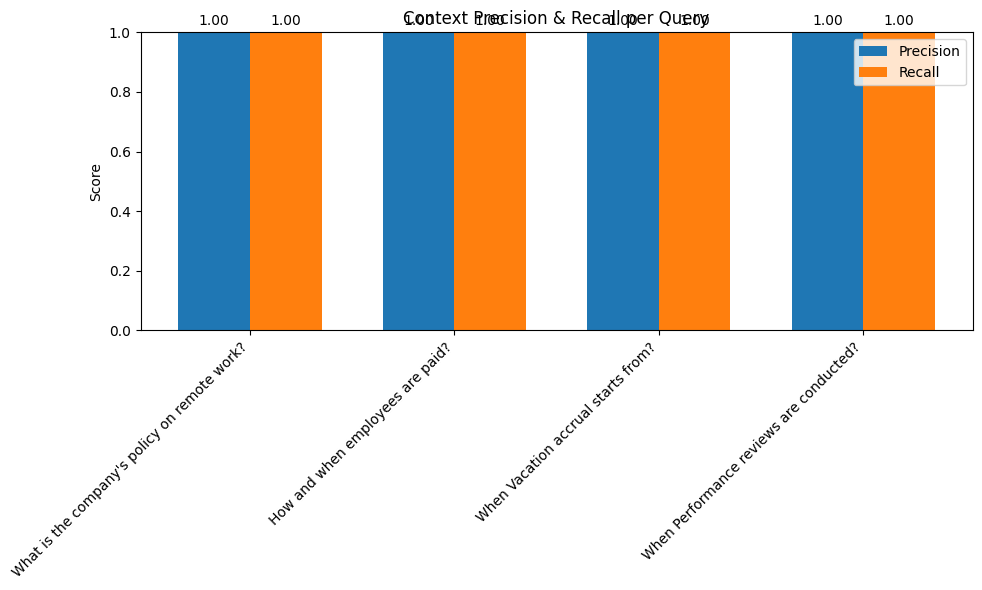

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(results_list)

labels = df["question"]
precision = df["precision"]
recall = df["recall"]

x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, precision, width, label='Precision')
rects2 = ax.bar(x + width/2, recall, width, label='Recall')

# Add labels
ax.set_ylabel('Score')
ax.set_title('Context Precision & Recall per Query')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylim(0, 1)  # metrics are between 0 and 1
ax.legend()

# Annotate bars with values
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()